# FIFA 2024 ⚽

Yuval Cohen, Noam Barak

***In this notebook, we will examine and analyze the EA FC24 player rating dataset.
We will attempt to model how the game calculates a player's overall score based on their attributes.***

## Constants

In [789]:
SKIP_MODELS = True
SKIP_1ST_GENDER_EXP = True 
SKIP_2ND_GENDER_EXP = True
SKIP_3RD_GENDER_EXP = True
SKIP_RFE = True
SKIP_BEST_PARMS = True

## Imports

In [790]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import xgboost as XGB
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import json
import shap
from IPython.display import Image, display
import warnings
warnings.filterwarnings('ignore')

# **Exploring The Data**

In [791]:
df = pd.read_csv('all_players.csv', index_col = 0)

In [792]:
df.head()

,Name,Nation,Club,Position,Age,Overall,Pace,Shooting,Passing,Dribbling,...,Strength,Aggression,Att work rate,Def work rate,Preferred foot,Weak foot,Skill moves,URL,Gender,GK
0,Kylian Mbappé,France,Paris SG,ST,24,91,97,90,80,93,...,77,64,High,Low,Right,4,5,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
1,Erling Haaland,Norway,Manchester City,ST,23,91,89,93,66,79,...,93,87,High,Medium,Left,3,3,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
2,Kevin De Bruyne,Belgium,Manchester City,CM,32,91,72,88,94,86,...,74,75,High,Medium,Right,5,4,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
3,Lionel Messi,Argentina,Inter Miami CF,CF,36,90,80,87,90,96,...,68,44,Low,Low,Left,4,4,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN
4,Karim Benzema,France,Al Ittihad,CF,35,90,79,88,83,87,...,82,63,Medium,Medium,Right,4,4,https://www.ea.com/games/ea-sports-fc/ratings/...,M,NaN


**As we can see, the data contains some categorical features, and a few categories have high cardinality, such as Nation or Club. We'll handle the categorical values while adding as few new columns as possible to avoid sparse data**

## **Lets Review Our Overall Score distribution**

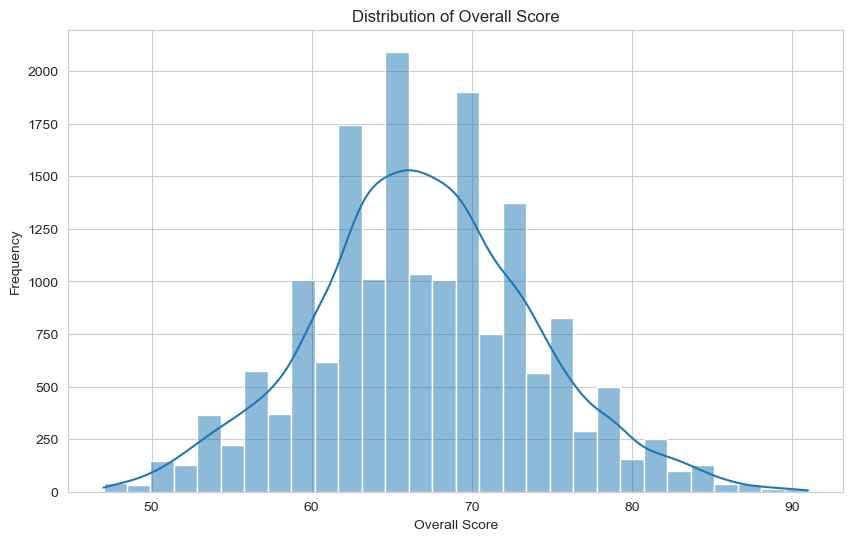

In [793]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Overall'], bins=30, kde=True)
plt.title('Distribution of Overall Score')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.show()

## It's important to note that our dataset encompasses both male and female players; let's explore the differences.

---



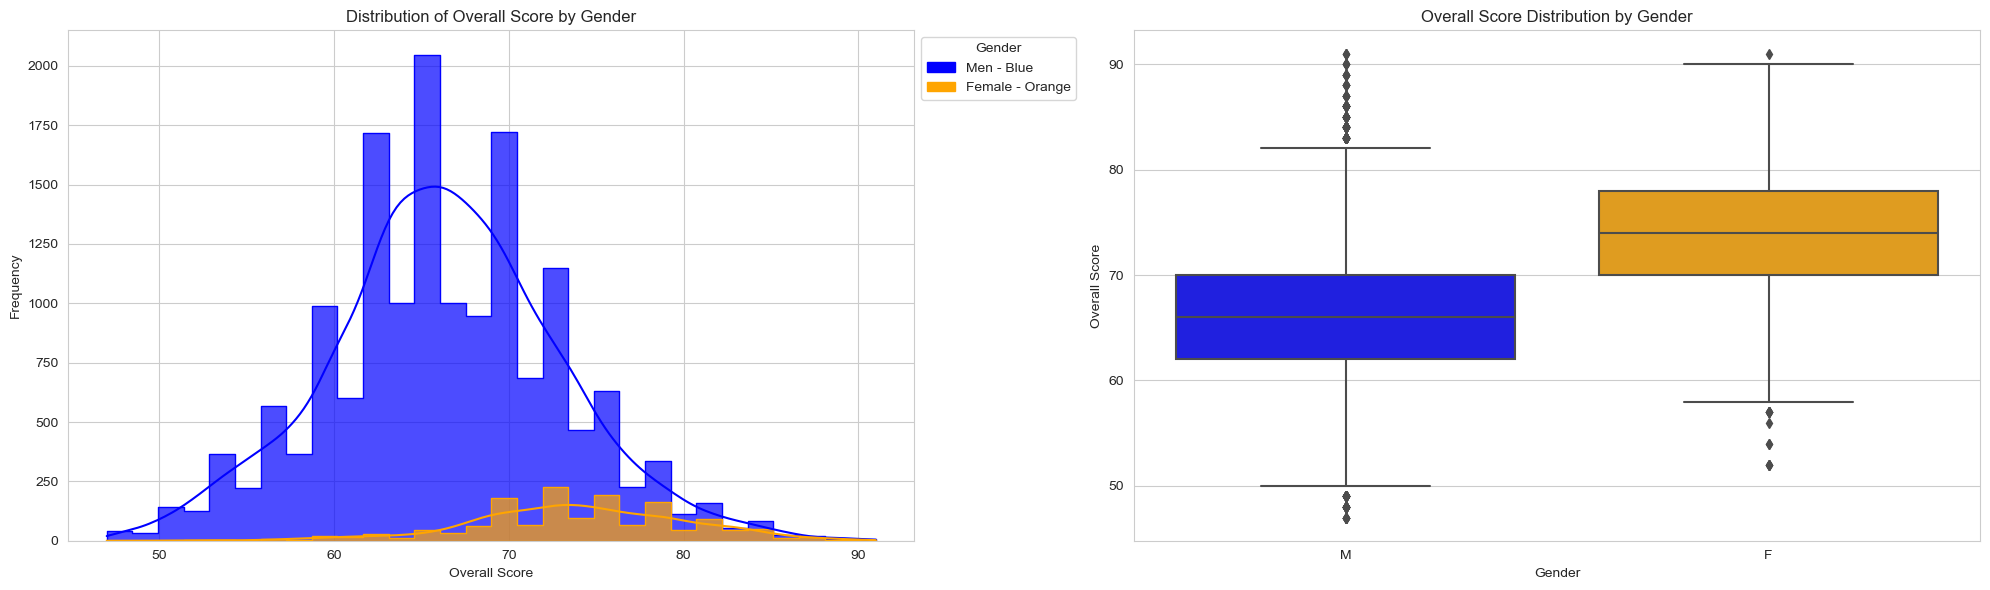

In [794]:
sns.set_style("whitegrid")
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Overall', hue='Gender', bins=30, kde=True, palette={'F': 'orange', 'M': 'blue'}, element="step", alpha=0.7, hue_order=['F', 'M'])
plt.title('Distribution of Overall Score by Gender')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
legend_elements = [Patch(facecolor='blue', edgecolor='blue', label='Men - Blue'),
                   Patch(facecolor='orange', edgecolor='orange', label='Female - Orange')]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), title='Gender')
plt.subplot(1, 2, 2)
sns.boxplot(x='Gender', y='Overall', data=df, palette={'F': 'orange', 'M': 'blue'})
plt.title('Overall Score Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Overall Score')
plt.tight_layout()
plt.show()


### The distribution between male and female players is notably different. In this project, we will investigate whether this discrepancy affects the performance of the model. ###

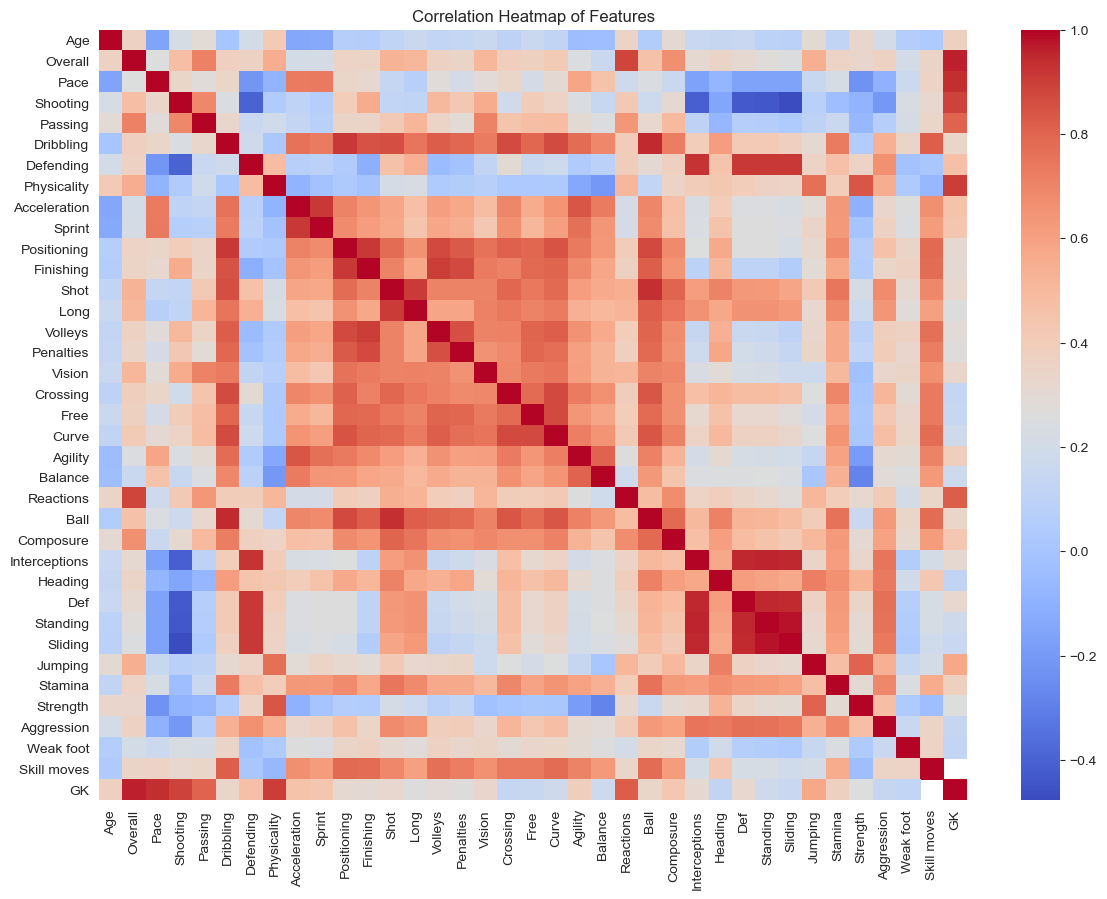

In [795]:
sample_features = df.columns[:]
# corr_sample = df[sample_features].corr(numeric_only=True)
corr_sample = df[sample_features].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_sample, cmap='coolwarm', fmt=".1f", annot=False)
plt.title('Correlation Heatmap of Features')
plt.show()

We can see that there are a few highly correlated features (for example, 'Def' and 'Standing'). Later in this project, we will try to eliminate some of them.

### Given the extensive number of features, it's challenging to discern which are most influential. Therefore, let's focus on identifying the top 20 features that have the strongest correlation with the Overall score.

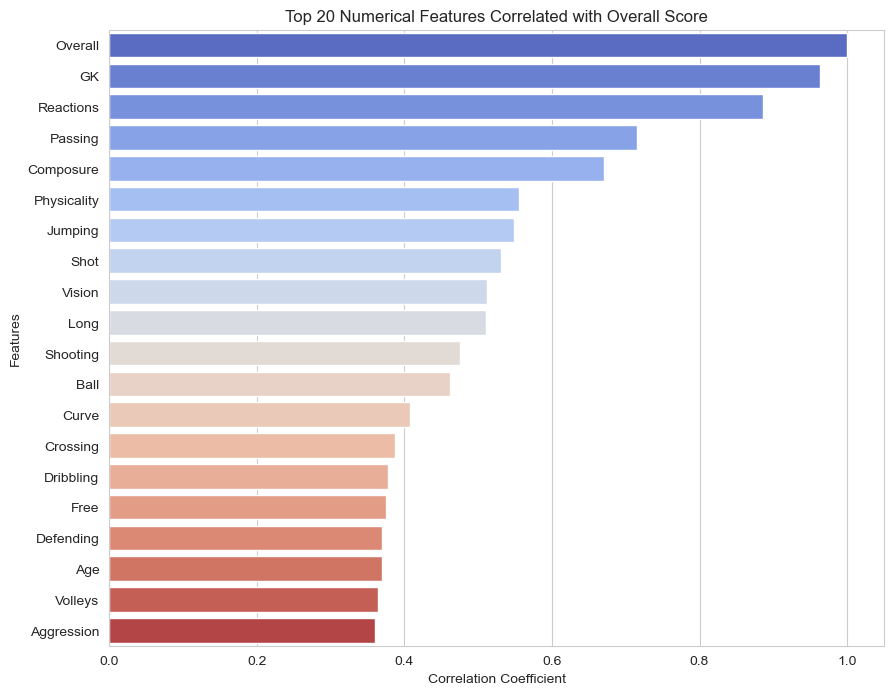

In [796]:
numeric_columns = df.select_dtypes(include='number')
correlation_with_overall_recalc = numeric_columns.corr()['Overall'].sort_values(ascending=False).head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_with_overall_recalc.values, y=correlation_with_overall_recalc.index, palette='coolwarm')
plt.title('Top 20 Numerical Features Correlated with Overall Score')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

# **Pre-Proccesing**

# Missing Values

---


### It's evident that there's an unusually high correlation between the Goalkeeper (GK) attributes and the Overall score. Let's proceed to check for any missing values in our dataset to ensure our analysis is accurate.

In [797]:
df.isna().sum()

Name                  0
Nation                0
Club                  0
Position              0
Age                   0
Overall               0
Pace                  0
Shooting              0
Passing               0
Dribbling             0
Defending             0
Physicality           0
Acceleration          0
Sprint                0
Positioning           0
Finishing             0
Shot                  0
Long                  0
Volleys               0
Penalties             0
Vision                0
Crossing              0
Free                  0
Curve                 0
Agility               0
Balance               0
Reactions             0
Ball                  0
Composure             0
Interceptions         0
Heading               0
Def                   0
Standing              0
Sliding               0
Jumping               0
Stamina               0
Strength              0
Aggression            0
Att work rate         0
Def work rate         0
Preferred foot        0
Weak foot       

The GK column, which details the goalkeeping abilities of players, lacks data for all non-goalkeeping players, yet it holds significant value for goalkeepers. Rather than discarding this column, we will assign a value of -1 to all non-goalkeepers. This approach allows us to differentiate between players with no goalkeeping abilities (indicated by 0) and those for whom the information is simply not available.

This will also address the correlation issue we observed earlier.

In [798]:
df['GK'] = df['GK'].fillna(-1) # fill value for any none GK

Let's measure the correlation of Goalkeeping (GK) attributes to the Overall Score compared to the rest of the features.

In [799]:
def correlation_rank(df, column_name):
    numeric_cols = df.select_dtypes(include=['number']).columns.drop('Overall')
    correlations = df[numeric_cols].apply(lambda x: x.corr(df['Overall']))
    ranked_correlations = correlations.abs().sort_values(ascending=False)
    rank = ranked_correlations.index.get_loc(column_name) + 1
    print("Rank of '{}' compared to 'Overall Score': {}/{}".format(column_name, rank, len(numeric_cols)))
correlation_rank(df, 'GK')


Rank of 'GK' compared to 'Overall Score': 36/36



## Handling Categorical Features

---


Now, let's identify the categorical features present in our dataset to understand how they're structured and determine the best approach for handling them in our analysis.

In [800]:
# Finding all features in the dataset that contain string values
string_features = df.select_dtypes(include='object').columns
string_features.tolist()

['Name',
 'Nation',
 'Club',
 'Position',
 'Att work rate',
 'Def work rate',
 'Preferred foot',
 'URL',
 'Gender']

In our previous submission, we handled most categorical data in the same manner: one-hot encoding. However, in some cases, although this approach might yield the desired outcome, particularly when the category being encoded has high cardinality, it results in a very sparse vector. This increase in parameter count significantly, potentially compromising our model's performance.

lets examine the amount of distinct values each category has

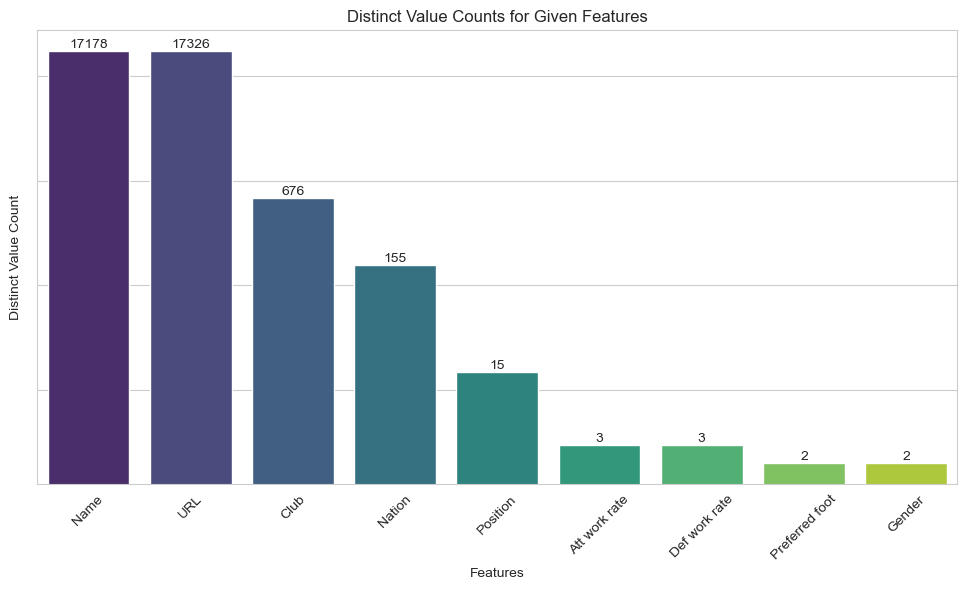

In [801]:
def count_distinct_values(df, column_name):
    return df[column_name].nunique()

columns_to_check = ['Name', 'URL', 'Club', 'Nation', 'Position', 'Att work rate', 
                    'Def work rate', 'Preferred foot', 'Gender']


distinct_counts = {col: count_distinct_values(df, col) for col in columns_to_check}
distinct_df = pd.DataFrame(list(distinct_counts.items()), columns=['Column', 'Distinct Count'])
plt.figure(figsize=(10, 6))
plot = sns.barplot(data=distinct_df, x='Column', y='Distinct Count', palette='viridis')
plt.yscale('log')
plt.xlabel("Features")
plt.ylabel("Distinct Value Count")
plt.title("Distinct Value Counts for Given Features")
plt.xticks(rotation=45)
plt.tight_layout()
for p in plot.patches:
    height = p.get_height()  # Get the height of the bar
    plot.text(p.get_x() + p.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=10)
plot.set_yticklabels([])  # Hide the numbers
plot.tick_params(axis='y', left=False) 
plt.show()

***URL Column***

Clearly, the URL column is redundant, the amount of values is as the amount of rows in our data, it shows no significat and has no numeric value

***Name Column***

While the Name column may not be directly useful for modeling, it facilitates easier visualization and interpretation of the results. Therefore, we'll retain the Name column

***Nation Column***

The 'Nation' column presents a ***high cardinality*** issue, implying a vast number of unique values that can lead to a sparse and inefficient representation when applying one-hot encoding.

Alternatively, label encoding would introduce a false hierarchy of nations, as there is inherently no ordinal relationship between countries, which could mislead the model.

Moreover, from the standpoint of **fairness**, including nationality in player evaluations could inadvertently introduce biases and skew the data analysis against the principle of fair play and equal representation. Thus, for both analytical accuracy and the integrity of fairness in sport, the 'Nation' column should be **omitted** from our dataset.



In [802]:
df.drop(['URL','Nation'], axis=1, inplace=True)

***Club Column***


Regarding the Club column, we've encountered dilemmas. Since this is a video game based on football teams, we speculate whether there might be any correlation between a player's score and the team they play for. Our theory revolves around the idea that biases exist; we tend to believe that an item's (in our case, a player's) value is influenced by its association with a specific brand (in our case, a team). We suspect this might hold true in our case as well.

However, we face a challenge due to the high number of clubs in our dataset (676). To address this, we drew inspiration from the video game itself. In the game, each club is assigned a rank between 1/2 stars to 5 stars, reflecting its rank. We propose to ***map each club to its corresponding star rank.*** This way, we can maintain information regarding the club's rank without explicitly storing the club names.

Therefore, we've crawled the web and obtained this information. Let's load it.

In [803]:
unique_clubs_df = pd.read_csv('club_rating.csv')

In [804]:
df = df.merge(unique_clubs_df, left_on='Club', right_on='Unique Clubs', how='left')
df.drop(columns=['Unique Clubs','Club'], inplace=True)
df.head()

,Name,Position,Age,Overall,Pace,Shooting,Passing,Dribbling,Defending,Physicality,...,Strength,Aggression,Att work rate,Def work rate,Preferred foot,Weak foot,Skill moves,Gender,GK,club_rating
0,Kylian Mbappé,ST,24,91,97,90,80,93,36,78,...,77,64,High,Low,Right,4,5,M,-1.0,10
1,Erling Haaland,ST,23,91,89,93,66,79,45,88,...,93,87,High,Medium,Left,3,3,M,-1.0,10
2,Kevin De Bruyne,CM,32,91,72,88,94,86,65,78,...,74,75,High,Medium,Right,5,4,M,-1.0,10
3,Lionel Messi,CF,36,90,80,87,90,96,33,64,...,68,44,Low,Low,Left,4,4,M,-1.0,7
4,Karim Benzema,CF,35,90,79,88,83,87,39,78,...,82,63,Medium,Medium,Right,4,4,M,-1.0,8


***Preferred foot Column***

This attribute has only two values, Right or Left. We can classify it as binary (Is the player right-footed?).

***Gender Column***

This attribute has only two values, Female or Male. Similarly, we can classify it as a question with a binary answer as well (Is this a male player?).


In [805]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Preferred foot'] = label_encoder.fit_transform(df['Preferred foot'])


***Position Column***

Position has 15 values.

We suspected that there is no significant difference whether a player is a left-wing or right-wing. The same goes for other positions.

We tried to narrow it down to four main categories (or bins): Goalkeeper, Defense, Midfield, and Attack by creating four bins:


In [806]:
position_to_bin = {
    'GK': 'Goalkeeping',
    'CB': 'Defence',
    'LB': 'Defence',
    'RB': 'Defence',
    'LWB': 'Defence',
    'RWB': 'Defence',
    'CM': 'Midfield',
    'CDM': 'Midfield',
    'CAM': 'Midfield',
    'RM': 'Midfield',
    'LM': 'Midfield',
    'ST': 'Attack',
    'CF': 'Attack',
    'RW': 'Attack',
    'LW': 'Attack'
}

However, we saw a **drastic decrease** in model performance, therefore, we've decided to keep all 15 original values and use one hot encoding.

In [807]:
categorical_features = ['Position']
df = pd.get_dummies(df, columns=categorical_features)

***Attack Work Rate & Defence Work Rate Columns***

Before converting the 'Att work rate' and 'Def work rate' values to numerical, let's first examine their unique values to determine the best mapping strategy


In [808]:
att_work_rate_values = df['Att work rate'].unique()
def_work_rate_values = df['Def work rate'].unique()

att_work_rate_values, def_work_rate_values


(array(['High', 'Low', 'Medium'], dtype=object),
 array(['Low', 'Medium', 'High'], dtype=object))

Observing that the ranking within the Attack Work Rate and Defense Work Rate attributes is categorical but ***sequential in importance***, we should convert these categories into numerical values. This approach maintains the ordinal nature of these ratings, ensuring that the model accurately reflects the ***hierarchy of work rates***.

In [809]:
# Mapping 'Low', 'Medium', 'High' to 1, 2, 3 for both 'Att work rate' and 'Def work rate'
work_rate_mapping = {'Low': 1, 'Medium': 2, 'High': 3}
df['Att work rate'] = df['Att work rate'].map(work_rate_mapping)
df['Def work rate'] = df['Def work rate'].map(work_rate_mapping)

# Handling Outliers #

### Before we start handling the outliers, remember that in our previous submissions, the MSE result was: 0.66.

Let's explore the distribution of our feature values

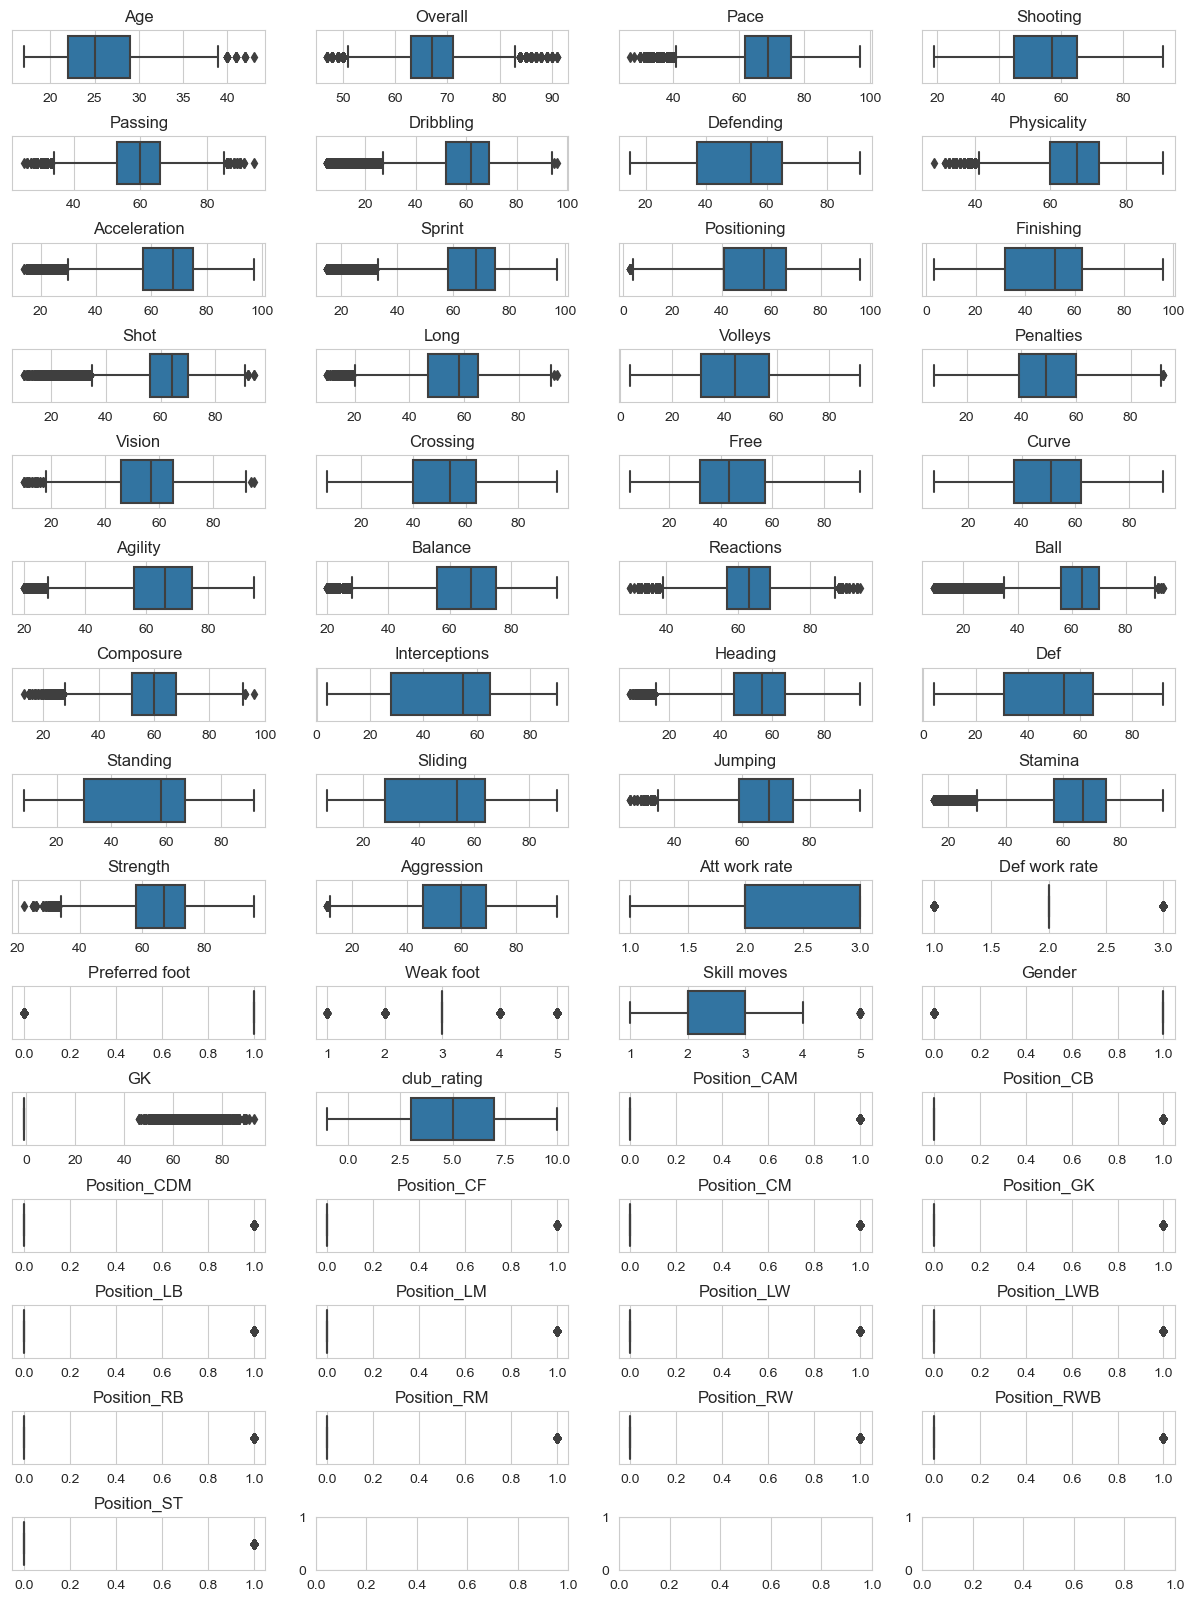

In [810]:
numeric_features = df.select_dtypes(include='number')
cols_amount = 4
rows_amount = int(len(numeric_features.columns)/cols_amount)+1
fig, axes = plt.subplots(nrows=rows_amount, ncols=cols_amount, figsize=(15,20))
fig.subplots_adjust(wspace=0.2, hspace=1)


for i, feature in enumerate(numeric_features.columns):
    row = int(i/cols_amount)
    col = i%cols_amount
    sns.boxplot(x=df[feature], ax=axes[row,col])
    axes[row, col].set_title(feature)
    axes[row, col].set_xlabel("")  # Remove x-axis labels

plt.show()

We may have some outliers; let's identify and address them.

There are columns that we need to preserve as-is because their values are discrete, unlike the rest, which are continuous. 
We must keep these values intact without fixing the outliers.

In [811]:
def is_outlier(feature, columns_to_ignore):
    if feature in columns_to_ignore:
        return False # Don't check this feature for outliers, as it should be preserved as-is
    
    # Calculate the quartiles and IQR
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1

    # Define the boundaries for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = df[feature][(df[feature] < lower_bound) | (df[feature] > upper_bound)]


    # Calculate the Z-scores
    z_scores = stats.zscore(df[feature])

    # Find outliers based on a Z-score threshold
    outliers = df[feature][(z_scores > 3) | (z_scores < -3)]

    return not outliers.empty


outliers_features = []

columns_to_ignore = ['Att work rate', 'Def work rate', 'Preferred foot', 'Weak foot', 'Skill moves', 'Gender', 'GK', 'club_rating' ]
columns_starting_with_position = [col for col in df.columns if col.startswith("Position_")]
columns_to_ignore.extend(columns_starting_with_position)

for feature in numeric_features.columns:
    if is_outlier(feature, columns_to_ignore) is True:
        outliers_features.append(feature)
        
print(f"Outliers features: \n{outliers_features}")


Outliers features: 
['Age', 'Overall', 'Pace', 'Passing', 'Physicality', 'Acceleration', 'Sprint', 'Shot', 'Long', 'Vision', 'Balance', 'Reactions', 'Composure', 'Jumping', 'Strength']


As we can see, we have quite a few outliers.The following method will calculate the interquartile range (IQR) and use it to define upper and lower bounds.

Values outside these bounds are then capped at the nearest boundary to mitigate their impact.

In [812]:
def fix_outliers(feature):
    q1 = feature.quantile(0.25)
    q3 = feature.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Cap the outliers to the lower and upper bounds
    return feature.clip(lower=lower_bound, upper=upper_bound)
    
for feature in outliers_features:
    df[feature] = fix_outliers(numeric_features[feature])

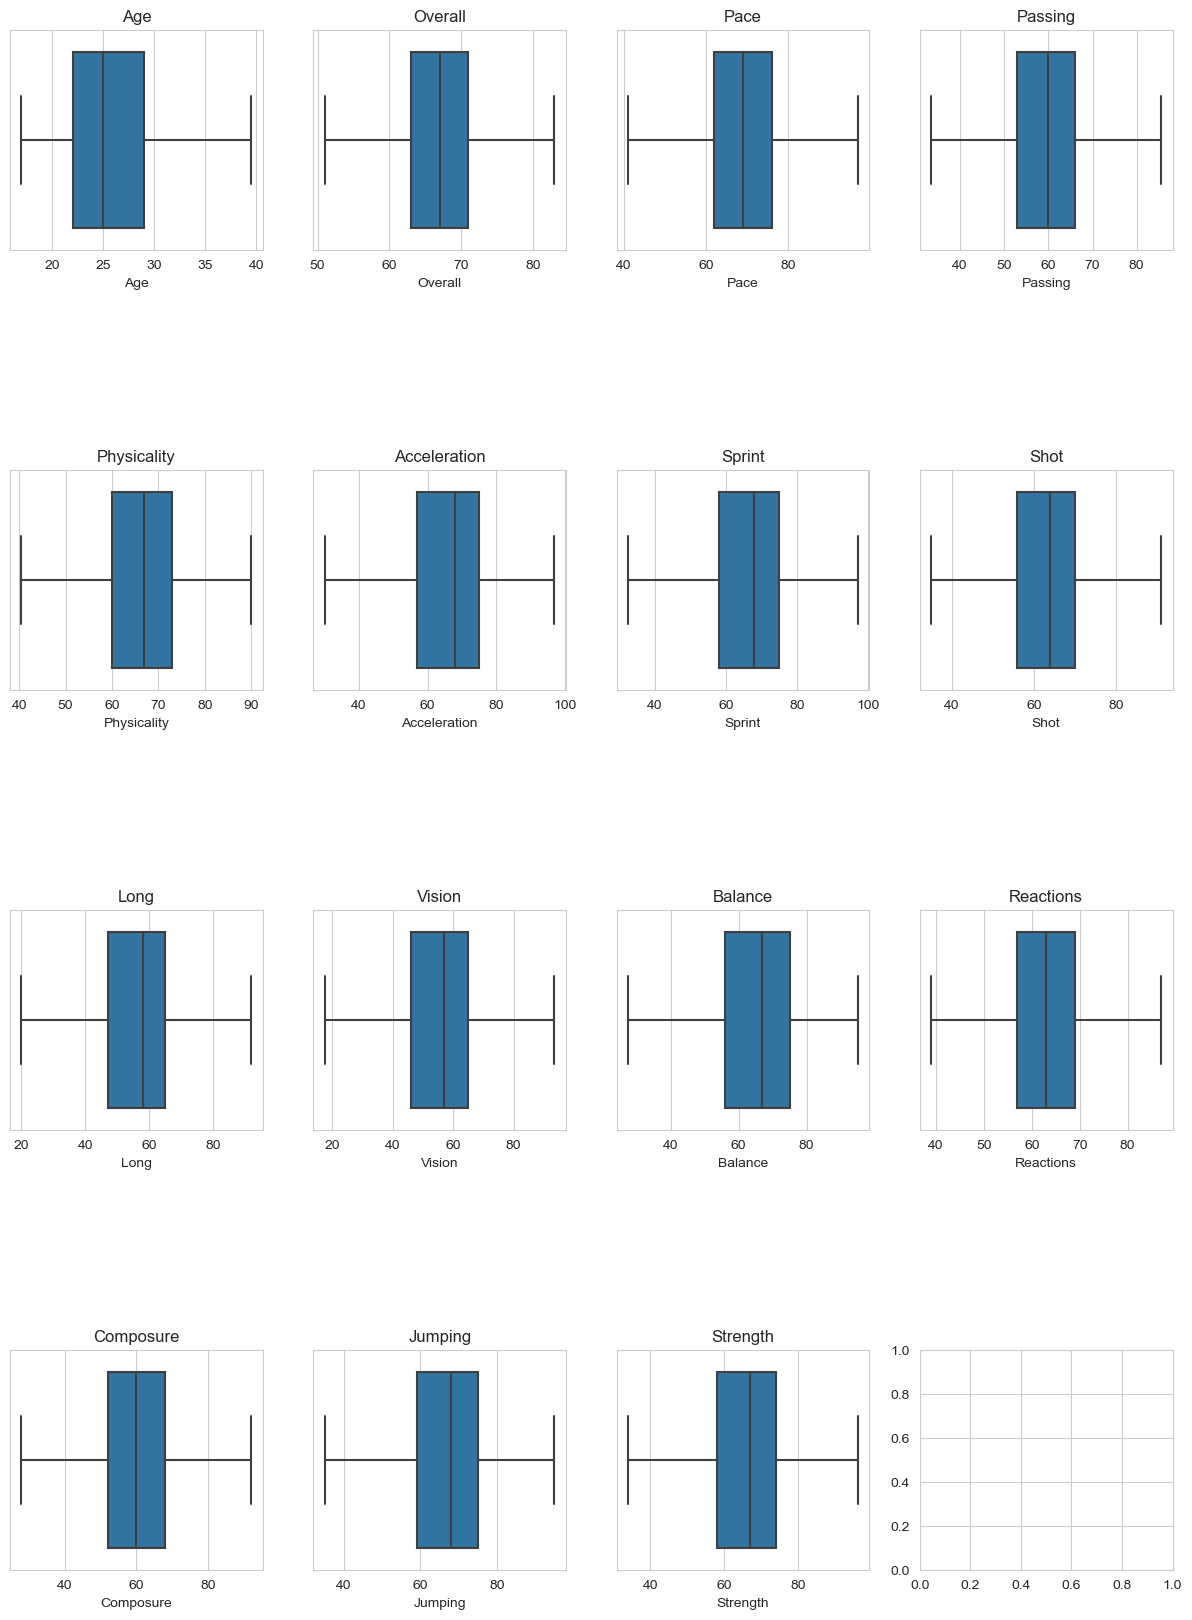

In [813]:
# Visualize the fixed data
cols_amount = 4
rows_amount = int(len(outliers_features)/cols_amount)+1
fig, axes = plt.subplots(nrows=rows_amount, ncols=cols_amount, figsize=(15,20))
fig.subplots_adjust(wspace=0.2, hspace=1)

for i, feature in enumerate(outliers_features):
    row = int(i/cols_amount)
    col = i%cols_amount
    sns.boxplot(x=df[feature], ax=axes[row,col])
    axes[row, col].set_title(feature)

plt.show()

# Choosing Our Model #

First, lets split the data to test and train

In [814]:
X_test,X,y_test, y = train_test_split(df.drop(['Overall'], axis=1), df['Overall'], test_size=0.9, random_state=42)
X, X_test, y, y_test = [
    x.reset_index(drop=True) for x in [X, X_test, y, y_test]
]

We have selected a few models that address regression issues.
These models are **XGBoost**, **Gradient Boosting**, **KNN** and **Linear Regression**.

Let's explore the options and determine which one we will use.

We will conduct 10-fold cross-validation, normalize our data within each fold to ensure our training set is correctly scaled with all four models to see which performs best.

For our evaluation metrics, we have chosen Mean Squared Error (**MSE**) and **R^2**, both of which are commonly used for regression model evaluation.

In [815]:
# Sample Data
# Assuming you have your data in X (features), y (target), and names (e.g., player names or other unique identifiers)
print("starting test")
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
# Initialize lists to store the performance metrics and predictions for each model
model_names = ['XGBoost', 'Gradient Boosting', 'Linear Regression', 'KNN']
models = [
    XGBRegressor(learning_rate=0.1, n_estimators=300, max_depth=5, random_state=101),
    RandomForestRegressor(n_estimators=100, random_state=42),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    LinearRegression(),
    KNeighborsRegressor(n_neighbors=5)
]

training_dataset= X.drop('Name',axis=1)

starting test


In [816]:
results = {}
if not SKIP_MODELS:
    for model_name, model in zip(model_names, models):
        print(f"training and testing {model_name}")
        mse_sum = 0
        r2_sum = 0
    
        for train_index, test_index in kf.split(training_dataset):
            # Split and scale the data
            X_train, X_valid = training_dataset.iloc[train_index], training_dataset.iloc[test_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    
            # Feature scaling
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_valid_scaled = scaler.transform(X_valid)
    
            # Fit the model
            model.fit(X_train_scaled, y_train)
    
            # Make predictions and calculate metrics
            y_pred = model.predict(X_valid_scaled)
            mse_sum += mean_squared_error(y_valid, y_pred)
            r2_sum += r2_score(y_valid, y_pred)
    
        # Store results for this model
        results[model_name] = {
            'MSE Scores': mse_sum / k,
            'R2 Scores': r2_sum / k
        }
        with open('models_results.json', 'w') as json_file:
            json.dump(results, json_file)
else:
    print("loading models results from file")
    with open('models_results.json', 'r') as json_file:
        results = json.load(json_file)


loading models results from file


In [817]:
for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print(f"MSE Scores: {result['MSE Scores']}")
    print(f"R2 Scores: {result['R2 Scores']} \n")

Results for XGBoost:
MSE Scores: 0.5946155916229322
R2 Scores: 0.9874129581974447 

Results for Gradient Boosting:
MSE Scores: 1.0716281750012333
R2 Scores: 0.9773114615833677 

Results for Linear Regression:
MSE Scores: 0.8737470480276912
R2 Scores: 0.9815045653521912 

Results for KNN:
MSE Scores: 3.41072629228137
R2 Scores: 0.9278393924381867 



***As we can see, XGBoost provides us with the best results; therefore, we will use it.***

### Gender Column Fairness and bias issues ##

As mentioned in the second submission, we observed that there are significantly fewer women than men in the dataset and that the score distribution differs from that of men. We aim to examine how female rankings are computed compared to males. Our goal is to determine the significance of the gender column and whether a different metric should be used for computing the overall score for females. To this end, we will conduct several experiments:

**1st Experiment.** Train and test with the gender column. Our training and testing sets will consist of a randomly created mix of females and males.

**2nd Experiment** Train and test without the gender column. The training and testing sets will again include a random mix of females and males.

**3rd Experiment** Train exclusively on the male dataset and assess performance on the female test dataset and on a similarly sized male test dataset.

In [818]:
#setup for the expirements

In [819]:
names_test = pd.DataFrame(X_test['Name'])
names_and_gender = X[['Name','Gender']]
X=X.drop(['Name'],axis=1)
X_without_gender = X.drop(['Gender'], axis=1) 
experiments_results = []

In [820]:
#this method will help us compute the metrics for each expirement
def expirement_results(predictions):
    
    # Prepare an empty list to hold the results
    results_list = []

    # Loop through each DataFrame in the list
    for dataframe in predictions:
        # Calculate MSE for females
        mse_female = mean_squared_error(
            dataframe[dataframe['Gender'] == 0]['Actual Overall'],
            dataframe[dataframe['Gender'] == 0]['Predicted Value']
        )

        # Calculate MSE for males
        mse_male = mean_squared_error(
            dataframe[dataframe['Gender'] == 1]['Actual Overall'],
            dataframe[dataframe['Gender'] == 1]['Predicted Value']
        )

        # Calculate MSE overall
        mse_overall = mean_squared_error(
            dataframe['Actual Overall'],
            dataframe['Predicted Value']
        )

        # Calculate R2 for females
        r2_female = r2_score(
            dataframe[dataframe['Gender'] == 0]['Actual Overall'],
            dataframe[dataframe['Gender'] == 0]['Predicted Value']
        )

        # Calculate R2 for males
        r2_male = r2_score(
            dataframe[dataframe['Gender'] == 1]['Actual Overall'],
            dataframe[dataframe['Gender'] == 1]['Predicted Value']
        )

        # Calculate R2 overall
        r2_overall = r2_score(
            dataframe['Actual Overall'],
            dataframe['Predicted Value']
        )

        # Append results to the list
        results_list.append({
            'MSE Female': mse_female,
            'MSE Male': mse_male,
            'MSE Overall': mse_overall,
            'R2 Female': r2_female,
            'R2 Male': r2_male,
            'R2 Overall': r2_overall
        })
    return pd.DataFrame(results_list)

***Experiment 1 (Training and Testing with Gender Column)***

In [821]:
# Lists to store performance metrics and predictions with names and gender for each fold
mse_scores = []
r2_scores = []
predictions_1st_exp = []
if not SKIP_1ST_GENDER_EXP:
    for train_index, test_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
        names_and_gender_valid = names_and_gender.iloc[test_index]
    
        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)
    
        # Initialize and fit the model
        xgb_model = XGBRegressor(learning_rate=0.1, n_estimators=300, max_depth=5, random_state=101)
        xgb_model.fit(X_train_scaled, y_train)
    
        # Make predictions on the validation set
        y_pred = xgb_model.predict(X_valid_scaled)
    
        # Store predictions with names and gender
        predictions_1st_exp.append(pd.DataFrame({
            'Player Name': names_and_gender_valid['Name'].reset_index(drop=True),
            'Gender': names_and_gender_valid['Gender'].reset_index(drop=True),
            'Actual Overall': y_valid.reset_index(drop=True),
            'Predicted Value': y_pred
        }))
    with open('predictions_1st_exp.pkl', 'wb') as file:
        pickle.dump(predictions_1st_exp, file)
else:
    print("loading predictions_1st_exp results from file")
    with open('predictions_1st_exp.pkl', 'rb') as file:
        predictions_1st_exp = pickle.load(file)

loading predictions_1st_exp results from file


****compute metrics****

In [822]:
results_df = expirement_results(predictions_1st_exp) 

results_1st_exp = pd.DataFrame(results_df.mean()).transpose()
experiments_results.append(results_1st_exp)
print(results_1st_exp)

   MSE Female  MSE Male  MSE Overall  R2 Female   R2 Male  R2 Overall
0    0.678019  0.586583     0.594616   0.979849  0.986481    0.987413


***Experiment 2 (Training and Testing without Gender Column)***

In [823]:
# Lists to store performance metrics and predictions with names and gender for each fold
mse_scores = []
r2_scores = []
predictions_2nd_exp = []
if not SKIP_2ND_GENDER_EXP:
    for train_index, test_index in kf.split(X_without_gender):
        X_train, X_valid = X_without_gender.iloc[train_index], X_without_gender.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
        names_and_gender_valid = names_and_gender.iloc[test_index]
    
        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)
    
        # Initialize and fit the model
        xgb_model = XGBRegressor(learning_rate=0.1, n_estimators=300, max_depth=5, random_state=101)
        xgb_model.fit(X_train_scaled, y_train)
    
        # Make predictions on the validation set
        y_pred = xgb_model.predict(X_valid_scaled)
    
        # Store predictions with names and gender
        predictions_2nd_exp.append(pd.DataFrame({
            'Player Name': names_and_gender_valid['Name'].reset_index(drop=True),
            'Gender': names_and_gender_valid['Gender'].reset_index(drop=True),
            'Actual Overall': y_valid.reset_index(drop=True),
            'Predicted Value': y_pred
        }))
    
        # Calculate and store MSE and R2 for this fold
        mse_scores.append(mean_squared_error(y_valid, y_pred))
        r2_scores.append(r2_score(y_valid, y_pred))
        
        with open('predictions_2nd_exp.pkl', 'wb') as file:
            pickle.dump(predictions_2nd_exp, file)
else:
    print("loading predictions_2nd_exp results from file")
    with open('predictions_2nd_exp.pkl', 'rb') as file:
        predictions_2nd_exp = pickle.load(file)

loading predictions_2nd_exp results from file


****compute metrics****

In [824]:
results_df = expirement_results(predictions_2nd_exp) 

results_2nd_exp = pd.DataFrame(results_df.mean()).transpose()
experiments_results.append(results_2nd_exp)
print(results_2nd_exp)

   MSE Female  MSE Male  MSE Overall  R2 Female   R2 Male  R2 Overall
0    0.684193  0.581525     0.590444   0.979643  0.986596    0.987502


***Experiment 3 (Training on Male Data, Testing on Both Genders)***

In [825]:
# Assuming X, y, and names_and_gender are predefined
# Split the dataset based on gender
male_indices = names_and_gender[names_and_gender['Gender'] == 1].index
female_indices = names_and_gender[names_and_gender['Gender'] == 0].index

# Lists to store performance metrics and predictions with names and gender for each fold
mse_scores = []
r2_scores = []
predictions_with_names_and_gender = []
mse_scores_male = []
mse_scores_female = []
r2_scores_male = []
r2_scores_female = []

In [826]:
if not SKIP_3RD_GENDER_EXP:
    results={}
    for train_index, test_index in kf.split(male_indices):
        # Split males for training
        X_train, y_train = X_without_gender.iloc[male_indices[train_index]], y.iloc[male_indices[train_index]]
    
        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
    
        # Initialize and fit the model
        xgb_model = XGBRegressor(learning_rate=0.1, n_estimators=300, max_depth=5, random_state=101)
        xgb_model.fit(X_train_scaled, y_train)
    
        # Ensure the test set is balanced
        male_test_indices = male_indices[test_index]
        num_females_available = len(female_indices)
        if len(male_test_indices) > num_females_available:
            male_test_indices = np.random.choice(male_test_indices, size=num_females_available, replace=False)
        female_test_indices = np.random.choice(female_indices, size=len(male_test_indices), replace=False)
    
        # Testing on the combined set
        combined_test_indices = np.concatenate((male_test_indices, female_test_indices))
        np.random.shuffle(combined_test_indices)
        X_valid, y_valid = X_without_gender.iloc[combined_test_indices], y.iloc[combined_test_indices]
        names_and_gender_valid = names_and_gender.iloc[combined_test_indices]
        X_valid_scaled = scaler.transform(X_valid)
    
        # Make predictions
        y_pred = xgb_model.predict(X_valid_scaled)
    
        # Store predictions
        predictions_with_names_and_gender.append(pd.DataFrame({
            'Player Name': names_and_gender_valid['Name'].reset_index(drop=True),
            'Gender': names_and_gender_valid['Gender'].reset_index(drop=True),
            'Actual Overall': y_valid.reset_index(drop=True),
            'Predicted Value': y_pred
        }))
    
        # Calculate and store MSE and R2 for this fold
        mse_scores.append(mean_squared_error(y_valid, y_pred))
        r2_scores.append(r2_score(y_valid, y_pred))
    
        # Separate performance metrics for males and females
        mse_scores_male.append(mean_squared_error(
            y_valid[names_and_gender_valid['Gender'] == 1], 
            y_pred[names_and_gender_valid['Gender'] == 1]))
        mse_scores_female.append(mean_squared_error(
            y_valid[names_and_gender_valid['Gender'] == 0], 
            y_pred[names_and_gender_valid['Gender'] == 0]))
        r2_scores_male.append(r2_score(
            y_valid[names_and_gender_valid['Gender'] == 1], 
            y_pred[names_and_gender_valid['Gender'] == 1]))
        r2_scores_female.append(r2_score(
            y_valid[names_and_gender_valid['Gender'] == 0], 
            y_pred[names_and_gender_valid['Gender'] == 0]))
    
    results['average_combined_mse'] = np.mean(mse_scores)
    results['average_combined_r2'] = np.mean(r2_scores)
    results['average_male_mse'] = np.mean(mse_scores_male)
    results['average_female_mse'] = np.mean(mse_scores_female)
    results['average_male_r2'] = np.mean(r2_scores_male)
    results['average_female_r2'] = np.mean(r2_scores_female)
    
    with open('results_3rd_exp.pkl', 'wb') as file:
        pickle.dump(results, file)
else:
    print("loading results_3rd_exp results from file")
    with open('results_3rd_exp.pkl', 'rb') as file:
        results = pickle.load(file)


loading results_3rd_exp results from file


****compute metrics****

In [827]:
# Create DataFrame to display results as requested
results_3rd_exp = pd.DataFrame({
    'MSE Female': [results['average_female_mse']],
    'MSE Male': [results['average_male_mse']],
    'MSE Overall': [results['average_combined_mse']],
    'R2 Female': [results['average_female_r2']],
    'R2 Male': [results['average_male_r2']],
    'R2 Overall': [results['average_combined_r2']]
})

print(results_3rd_exp)
experiments_results.append(results_3rd_exp)

   MSE Female  MSE Male  MSE Overall  R2 Female   R2 Male  R2 Overall
0     1.00565  0.625026     0.815338    0.97083  0.985578    0.984823


***Experiments Summary***

In [828]:
for i, exp in enumerate(experiments_results,start=1):
    print(f"Experiment {i} Results:")
    print(f"{exp} \n")

Experiment 1 Results:
   MSE Female  MSE Male  MSE Overall  R2 Female   R2 Male  R2 Overall
0    0.678019  0.586583     0.594616   0.979849  0.986481    0.987413 

Experiment 2 Results:
   MSE Female  MSE Male  MSE Overall  R2 Female   R2 Male  R2 Overall
0    0.684193  0.581525     0.590444   0.979643  0.986596    0.987502 

Experiment 3 Results:
   MSE Female  MSE Male  MSE Overall  R2 Female   R2 Male  R2 Overall
0     1.00565  0.625026     0.815338    0.97083  0.985578    0.984823 



***Experiment 1 (Training and Testing with Gender Column)***

The model showed varying degrees of accuracy between male and female datasets when trained with gender data. This suggests that gender as a feature can influence the model's predictions, potentially leading to gender-based discrepancies in performance.

***Experiment 2 (Training and Testing without Gender Column)***

By removing the gender column, the model demonstrated minor changes overall in performance across genders.

***Experiment 3 (Training on Male Data, Testing on Both Genders)***

This setup highlighted a significant performance gap: the model trained exclusively on male data performed worse on the female dataset compared to the male dataset. This was a clear indication of how training data can bias a model, as it failed to generalize well across genders not represented during the training phase.

***Insights on Fairness and Model Training***

These experiments highlight the potential for gender bias in predictive modeling when training with gender as a feature or solely on one gender.
Such practices can result in models that perform unfairly across different groups.
To ensure equitable outcomes and uphold ethical modeling principles, we have decided to ****drop the gender column**** from our datasets.

This move helps mitigate bias and supports the development of models that perform well universally, fostering fairness and inclusivity in our machine learning applications.


In [829]:
df.drop(columns=['Gender'], inplace=True)
X.drop(columns=['Gender'], inplace=True)
X_test.drop(columns=['Gender'], inplace=True)

 # Feature Selection

***Using RFE (Recursive Feature Elimination)***

Currently, we are working with a dataset with over 50 parameters.
as mentioned before, we saw a few highly corrlated features and want to ensure there are no unnecessary parameters that could complicate our model, we have decided to use RFE.

RFE is a **feature selection method** that helps identify which variables are most important to a model's predictive power. It works by recursively removing the least important features, building the model using the remaining attributes, and calculating model accuracy. This process continues until all features in the dataset have been either included or excluded, thereby helping to optimize the model's performance by retaining only the most significant variables.

In [830]:
if not SKIP_RFE:
    estimator = XGBRegressor(learning_rate=0.1, n_estimators=300, max_depth=5, random_state=101)
    selector = RFECV(estimator, step=1, cv=kf, scoring='neg_mean_squared_error', min_features_to_select=20, verbose=1)
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('feature_selection', selector),
        ('regressor', estimator)
    ])
    pipeline.fit(X, y)
    best_n_features = selector.n_features_
    print(f"The optimal number of features: {best_n_features}")
    selected_features = X.columns[selector.support_]
    feature_importances = pipeline.named_steps['regressor'].feature_importances_
    sorted_features = sorted(zip(selected_features, feature_importances), key=lambda x: x[1], reverse=True)
    
    # Save the names of the selected features
    rfecv = pipeline.named_steps['feature_selection']
    selected_features = X.columns[rfecv.support_].tolist()
    
    #dump(selected_features, 'selected_features.joblib')
    with open('selected_features.json', 'w') as json_file:
        json.dump(selected_features, json_file)
else:
    print("loading selected_features from file")
    with open('selected_features.json', 'r') as json_file:
        selected_features = json.load(json_file)

loading selected_features from file


Let's find out which features were chosen.

In [831]:
print(f"{selected_features}")


['Pace', 'Shooting', 'Passing', 'Dribbling', 'Defending', 'Physicality', 'Acceleration', 'Sprint', 'Positioning', 'Finishing', 'Shot', 'Long', 'Volleys', 'Vision', 'Crossing', 'Reactions', 'Ball', 'Composure', 'Interceptions', 'Heading', 'Def', 'Standing', 'Sliding', 'Jumping', 'Stamina', 'Strength', 'Aggression', 'GK', 'club_rating', 'Position_CAM', 'Position_CB', 'Position_CDM', 'Position_CF', 'Position_CM', 'Position_LB', 'Position_LM', 'Position_LWB', 'Position_RB', 'Position_RM', 'Position_RWB', 'Position_ST']


As we can see, one of the features selected by RFE was **club_rating**, which we created earlier. This strongly indicates the value of this feature to the model's performance.

In [832]:
# Update our dataset
X = X[selected_features]
X_test = X_test[selected_features]

# **Optimizing Hyperparameters**
As seen before, our current best score achieved by XGBoost in the second experiment (where we dropped the gender column) is as follows:


Let's try to improve that by optimizing the hyperparameters of our chosen model, XGBoost.

In [833]:
# Define parameter grid
xgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

In [834]:
if not SKIP_BEST_PARMS:
    # Data structures to collect results
    results = {}
    predictions_with_names = []
    
    # Hyperparameter tuning for each model
    model = GridSearchCV(XGBRegressor(random_state=101), xgb_param_grid, cv=kf, n_jobs=-1)
    
    model.fit(X, y)
    best_params = model.best_params_
    
    # # Save best parameters to JSON
    with open(f"XGB_best_params.json", "w") as f:
        json.dump(best_params, f)
else:
    print("loading best params from file")
    with open("XGBoost_best_params.json", "r") as f:
        best_params = json.load(f)

loading best params from file


In [835]:
model = XGBRegressor(**best_params)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Scale the training data
X_test_scaled = scaler.transform(X_test)  # Apply the same transformation to test data
model.fit(X_scaled, y)
y_pred = model.predict(X_test_scaled)
mse_score = mean_squared_error(y_test, y_pred)
r2_score_value = r2_score(y_test, y_pred)
print("MSE Score:", mse_score)
print("R2 Score:", r2_score_value)


MSE Score: 0.5330328817735013
R2 Score: 0.9878335759075605


As we can see, we improved our model's performance by optimizing the hyperparameters.

### Model Performence Analysis

After analyzing and optimizing our data and model, let's dive deeper and examine how our model behaves using SHAP (SHapley Additive exPlanations).

This method will help us understand the impact of each feature on the model's predictions, providing insights into the relative importance and effect of each variable within the model.


PermutationExplainer explainer: 501it [00:57,  6.98it/s]                                                               


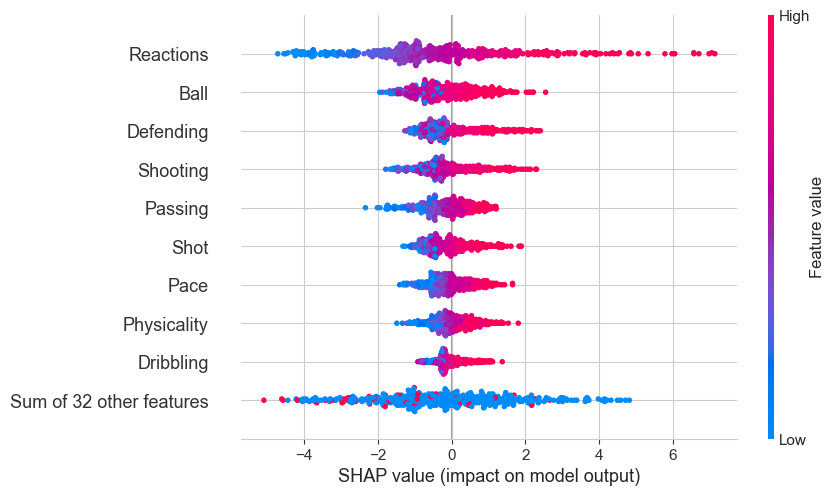

In [836]:
X_train_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

shap_sample = X_train_scaled_df.sample(500)
explainer = shap.Explainer(model.predict, shap_sample)
shap_values = explainer(shap_sample)
shap_values.feature_names = X_train_scaled_df.columns.tolist()
shap.plots.beeswarm(shap_values)

**Let's examine the features with the most impact:**

**Reactions**: Higher reaction values (red dots) tend to positively impact the model output, suggesting that quick reactions are valued by the model.

**Shooting**: Higher shooting values generally have a positive impact, indicating it's a key feature for the model's output.

**Defending**: This feature has a more mixed impact. While higher defending scores can lead to a positive impact, there's considerable variability in how it affects the model's predictions.

These results are intriguing. We originally thought that 'reactions' would primarily affect goalkeepers, but it appears to be the most valuable feature across all players. Additionally, we expected 'defending' to impact defensive players most, but it seems to influence all players.

This correlates with the real-life evaluation of a player; a top-class footballer these days cannot be merely a 'specialist' in one area of the game. Instead, each player should be able to perform well in all aspects of the game.



***Reaction is our most valuable feature, as mentioned before.***

***We did not expect this; let's dive into its correlation with one of the top features:***

In [837]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_scaled)

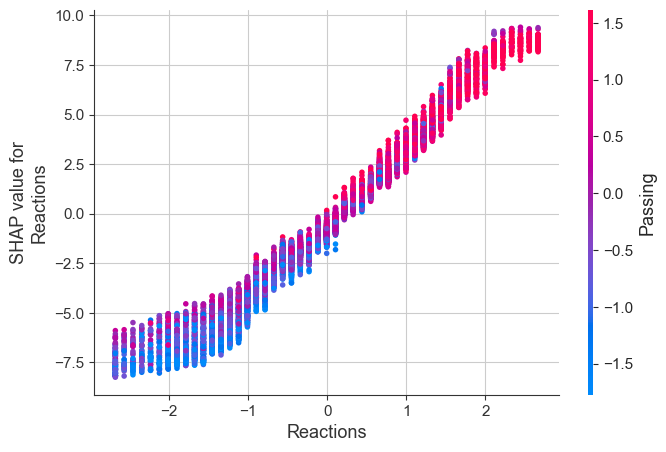

In [838]:
shap.dependence_plot("Reactions", shap_values, X_train_scaled_df)

Given the shape of the data distribution and the interaction between features, there seems to be a correlation between ***'Reactions'*** and ***'Passing'***. 

This correlation makes sense because football is a dynamic and fast-paced sport; if a player has quick reactions, they can respond swiftly to changing situations, leading to better passing ability.

### Error Analysis

In [839]:
pred_diff = y_pred - y_test

max_positive_diff_index = np.argmax(pred_diff)
max_positive_diff_player = names_test.iloc[max_positive_diff_index]

print("Player with the maximum positive difference:", max_positive_diff_player['Name'])
print("Difference value:", pred_diff[max_positive_diff_index])

Player with the maximum positive difference: Stav Nahmani
Difference value: 3.6568527221679688


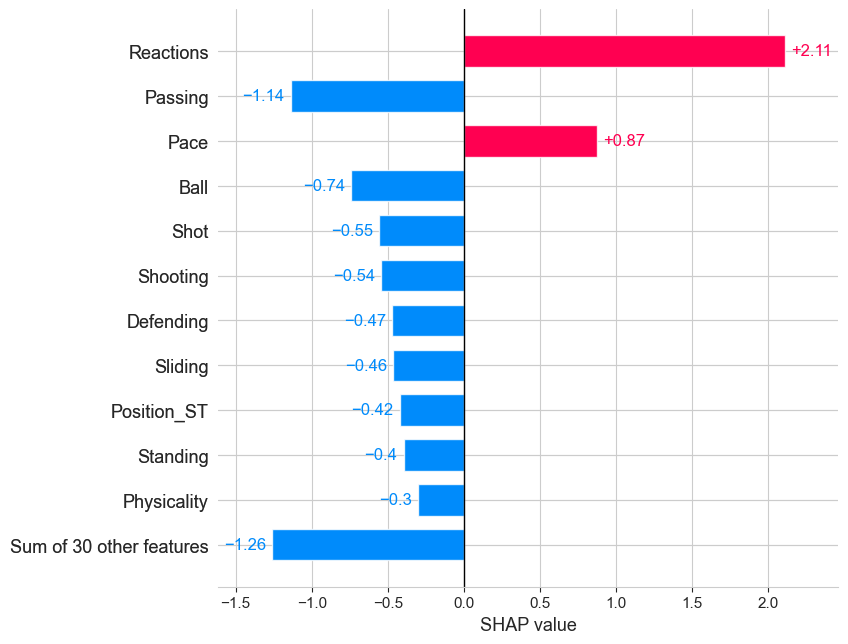

In [840]:
pos_player_idx = names_test.index[max_positive_diff_index]
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
shap.plots.bar(explainer(X_test_scaled_df)[pos_player_idx],max_display=12)

Our main assumption, based on these results, is that our model assigns **excessive weight to the 'reaction'** attribute. 

This overemphasis can ***skew the model's assessment***, leading it to overestimate a player's overall ability. 

Such disproportionate weighting might overshadow other critical attributes that contribute to a player's performance, potentially compromising the accuracy and reliability of the model's predictions.

-------------------------------------------------------------------------------------
#### ***Player Analysis - Mykhailo Mudryk***

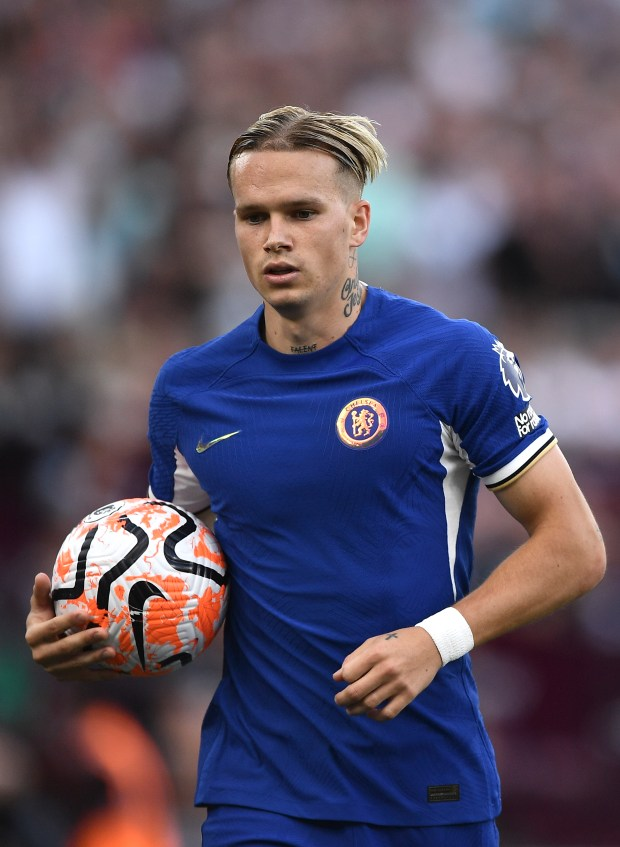

In [841]:
image_path = './mudryk.jpg'
# Specify the desired width and height (in pixels)
image_width = 200
image_height = 100

# Display the image with specified width and height
display(Image(filename=image_path, width=image_width, height=image_height))



Mykhailo Mudryk, 23 years old, born in Krasnohrad, Ukraine, has quickly risen to prominence in European football.
He plays as a winger for Chelsea FC and the Ukrainian national team.
Mudryk is renowned for his remarkable **pace**, **dribbling** ability, and **passing** on the field, making him a significant threat in attacking positions.
His style of play is characterized by his ability to quickly accelerate, maneuver through tight spaces, and deliver precise crosses.

Despite his offensive prowess, Mudryk is sometimes criticized for his defensive contributions, as he can occasionally be caught out of position or **make errors in defensive situations.** Nevertheless, his talent and potential are highly regarded, and he is seen as a player with a bright future in football.

***Let's see how our model assesses his abilities:***

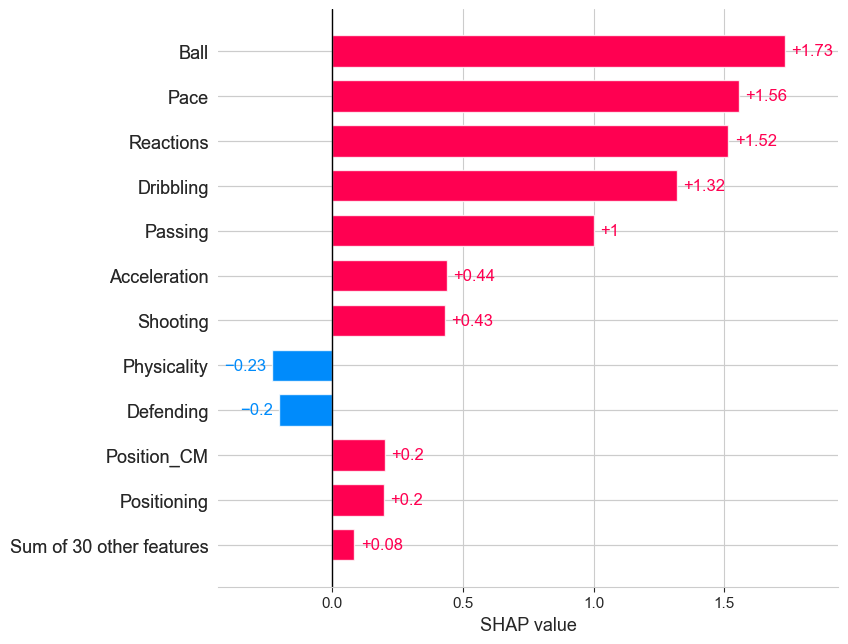

In [842]:
selected_player_idx = names_test.index[names_test['Name'] == 'Mykhailo Mudryk'][0]
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
shap.plots.bar(explainer(X_test_scaled_df)[selected_player_idx],max_display=12)


It can be seen that his reaction and passing enhance his rating with high corrlation as we showed before, while his defensive skills (Physicality, Defending) lowers it. This relates to what we mentioned earlier, suggesting that a player's defensive abilities are important even when discussing an attacking player.

## Code Notebook from Kaggle

We searched for similar notebooks on Kaggle and found one [notebook](https://www.kaggle.com/code/beratozmen/ea-sports-fc-24-predict-overall-with-xgboost)    
Like us, this notebook utilizes XGBoost. However, while our model achieved an MSE of 0.55, the MSE in that notebook is 0.8524.

It seems that while we accounted for various features and analyzed each one individually, their approach was to disregard categorical features and use only numerical ones. We believe this approach might be one of the primary reasons for the difference in the models' outcomes.

We searched for other notebooks but couldn't find any that analyzed each categorical feature or used additional datasets to improve the model, as we did.

## Summary

In this project, we've **analyzed the data, handled the outliers, and addressed the categorical features** , all while ensuring that we didn't create sparse data with too many columns, which could adversely affect the model's performance.

As part of our efforts to **avoid sparse data** , we found that classic approach (one-hot encoding, label encoding etc..) worked well for most categorical features. However, the 'Club Name' feature required a different approach. Using the actual club names in the model would have created too many columns, given that there are 676 unique clubs in FIFA 24. To address this, we **replaced 'Club Name' with 'Club Rate'** , a numerical representation from 1 to 10. This change significantly reduced the number of parameters and helped prevent data sparsity.

While creating the model, we prioritized **fairness** and aimed to develop a fair model by dropping the 'Nation' and 'Gender' features. This step ensures the model doesn't predict scores biased by a player's nationality or gender, even if it slightly affects the model's performance.

We **compared several models** and chose the **XGBoost** model because it yielded the best results. 
We also used **RFE** to find the best combination of features for our task. 
After implementing these steps, the model's MSE improved from **0.66** in our second submition to **0.53**.

In the final part, we displayed **SHAP** graphs to highlight the most significant features, illustrate how the model calculates the score for a specific player, and demonstrate the internal correlation between two features. We also explained how **each of these insights is relevant to real-life situations**.

Throughout the project, we aimed to create a **reliable and fair model**, ensuring that the results and conclusions align with actual player scores while also achieving high **accuracy**.

### References


* [EA FC 24 Players Dataset](https://www.kaggle.com/datasets/nyagami/fc-24-players-database-and-stats-from-easports)    

* [Club Rating Information](https://www.fifaindex.com/teams/fifa24/)    

* [Other people's work](https://www.kaggle.com/datasets/nyagami/fc-24-players-database-and-stats-from-easports/code)    